# A comparison between ECFP4, FCFP4, and TOP4 fingerprints

# Introduction

Here we will use the mapper algorithm to compare the spaces defined by ECFP4, FCFP4 and TOP4 fingerprints. We will use the following definitions:

- ECFP4: Morgan fingerprint, radius 2
- FCFP4: Morgan fingerprint, radius 2, similar functional groups considered the same
- TOP4: Morgan fingerprint, radius 2, only using uncolored, unweighted graphs

# Loading in Data

We will use the ZINC.FL dataset for this analysis.

In [1]:
import pandas as pd

ZINC_FL = pd.read_csv('../data/ZINC.FL/ZINC.FL.smi', sep=' ', header=0, names=['SMILES', 'DB_ID'])

n_molecules = len(ZINC_FL)

# Calculation of fingerprints

In [12]:
import numpy as np
from rdkit.Chem.rdMolDescriptors import CalcNumRings, CalcNumAromaticRings, CalcNumRotatableBonds
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, GetMorganFingerprintAsBitVect, NumRotatableBondsOptions
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.GraphDescriptors import BertzCT
from rdkit.Chem import MolFromSmiles
from rdkit import DataStructs
from ipywidgets import FloatProgress, HBox, Label
from IPython.display import display

def findCounts(s, ch):
    # Find number of times an element is in a smiles string. 
    # v.v. basic - Works for S, O, P etc, when we know nothing weird will be present
    # ignores aromaticity - always search for an uppercase string
    return len([letter for letter in s if letter.upper() == ch])

# Set up array to put fingerprints into
nBits = 512
r = 2
ECFP_arr = np.zeros((n_molecules, nBits))
FCFP_arr = np.zeros((n_molecules, nBits))
top_arr = np.zeros((n_molecules, nBits))

# Set up array to put descriptors into
desc_names = ['n_atom', 'n_ring', 'n_aro', 'n_rot', 'MW', 'LogP', 'Bertz', 'n_O', 'n_S', 'n_P']
n_descs = len(desc_names)
desc_arr = np.zeros((n_molecules, n_descs))
strictness = NumRotatableBondsOptions.StrictLinkages

# Set up progress bar
progressbar = FloatProgress(min=0, max=n_molecules, bar_style='success')
progressbox = HBox([Label('Calculation Progress'), progressbar])
display(progressbox)

for smiles_i, smiles in enumerate(ZINC_FL['SMILES']):
    
    # Create Molecule Object
    molecule = MolFromSmiles(smiles)
    
    
    ### ECFP
    ECFP_fingerprint = GetMorganFingerprintAsBitVect(molecule, r, nBits=nBits, useFeatures=False)
    
    #Put it into the fingerprint array
    arr = np.zeros((1,nBits),dtype='bool')
    DataStructs.ConvertToNumpyArray(ECFP_fingerprint,arr)
    ECFP_arr[smiles_i] = arr
    
    ### FCFP
    FCFP_fingerprint = GetMorganFingerprintAsBitVect(molecule, r, nBits=nBits, useFeatures=True)
    
    #Put it into the fingerprint array
    arr = np.zeros((1,nBits),dtype='bool')
    DataStructs.ConvertToNumpyArray(FCFP_fingerprint,arr)
    FCFP_arr[smiles_i] = arr
    
    ### top
    top_fingerprint = GetMorganFingerprintAsBitVect(molecule, r, nBits=nBits,
                                                    invariants=[1]*molecule.GetNumAtoms(), useBondTypes=False)
    
    #Put it into the fingerprint array
    arr = np.zeros((1,nBits),dtype='bool')
    DataStructs.ConvertToNumpyArray(top_fingerprint,arr)
    top_arr[smiles_i] = arr
    
    
    ### Descriptor calculation
    desc_arr[smiles_i, 0] = molecule.GetNumHeavyAtoms()
    desc_arr[smiles_i, 1] = CalcNumRings(molecule)
    desc_arr[smiles_i, 2] = CalcNumAromaticRings(molecule)
    desc_arr[smiles_i, 3] = CalcNumRotatableBonds(molecule, strict=strictness)
    desc_arr[smiles_i, 4] = CalcExactMolWt(molecule)
    desc_arr[smiles_i, 5] = MolLogP(molecule)
    desc_arr[smiles_i, 6] = BertzCT(molecule)
    desc_arr[smiles_i, 7] = findCounts(smiles, 'O') 
    desc_arr[smiles_i, 8] = findCounts(smiles, 'S')
    desc_arr[smiles_i, 9] = findCounts(smiles, 'P')
    
    # Tick up progressbar
    progressbar.value += 1

# Image Tooltips

In [16]:
from rdkit.Chem import Draw
import io
import base64
import numpy as np
from scipy.misc import toimage, imsave, imresize

### THIS FUNCTION TECHNICALLY APPEARS IN SCRIPTS --- We put it here in full.

def smi2image(smiles, size=300):
    """Turn a smiles string into an image"""
    molecule = MolFromSmiles(smiles)
    return Draw.MolToImage(molecule, size=[size,size])

# Set up progress bar
progressbar = FloatProgress(min=0, max=n_molecules, bar_style='success')
progressbox = HBox([Label('Calculation Progress'), progressbar])
display(progressbox)

tooltips = []
for smiles_i, smiles in enumerate(ZINC_FL['SMILES']):
    output = io.BytesIO()
    img = toimage(smi2image(smiles))
    img.save(output, format='PNG')
    contents = output.getvalue()
    img_encoded = base64.b64encode(contents)
    img_tag = """<p>
                 <div style="width:300px;
                            height:300px;
                            overflow:hidden;
                            float:left;
                            position:relative;">
                 <img src="data:image/png;base64,%s" style="position:absolute; top:0; right:0;
                                                            width: 300px; height: 300px;" />
                 </div>
                 </p>""" % (img_encoded.decode('utf-8'))
    tooltips.append(img_tag)
    progressbar.value += 1
tooltips = np.array(tooltips)

# Distributions of distances

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings(action='ignore')

def distance_distribution(fp_arr, n_samples=1, random_seed=42):
    molecule_indices = np.arange(len(fp_arr))

    # Plotting objects
    hist = plt.figure()
    histax = hist.add_subplot(111)
    cumsum = plt.figure()
    cumsumax = cumsum.add_subplot(111)

    np.random.seed(random_seed)
    for sample_n in range(n_samples):
        choice_molecule = np.random.choice(molecule_indices)
        mask = np.ones(n_molecules, dtype=bool)
        mask[choice_molecule] = False
        distances = pairwise_distances(fp_arr[choice_molecule].reshape(1,-1), fp_arr[mask], metric='jaccard')
        histvals = histax.hist(distances.flatten(), bins=100, normed=False, alpha=0.5)

        cumsumvals = histvals[0].cumsum()
        cumsumax.plot(histvals[1][1:],cumsumvals, alpha=0.5)

    n_nearest_cutoff = 100
    cumsumax.set_ylim([0,n_nearest_cutoff])
    cumsumax.set_xlabel('Tanimoto Distance')
    cumsumax.set_ylabel('Number of Molecules less than Distance')
    histax.set_xlabel('Tanimoto Distance')
    histax.set_ylabel('Number of Molecules')
    plt.show()

ECFP


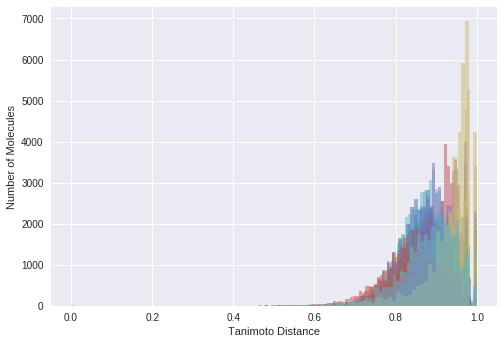

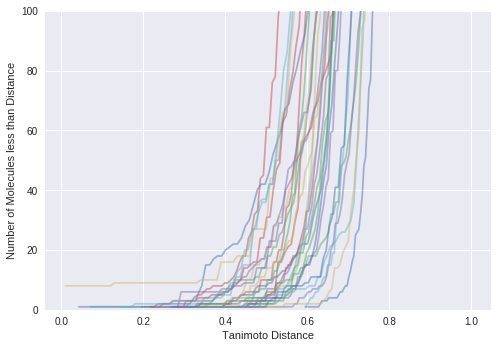

FCFP


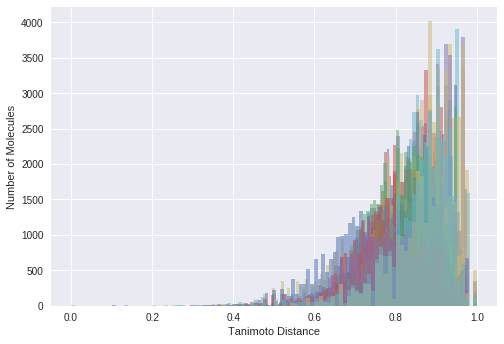

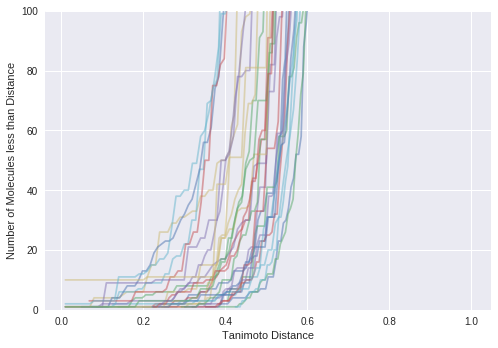

top


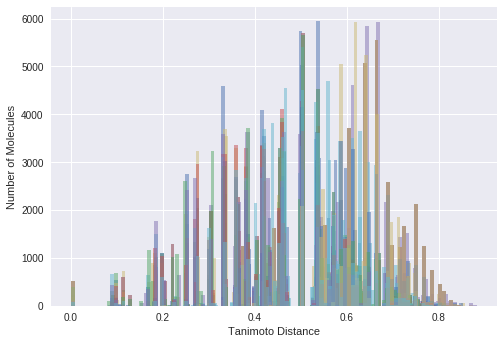

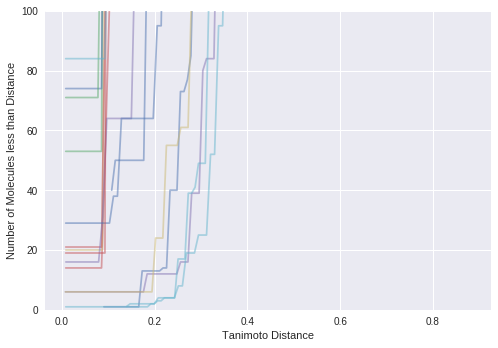

In [9]:
fingerprint_names = ['ECFP', 'FCFP', 'top']
for i, fp_arr in enumerate([ECFP_arr, FCFP_arr, top_arr]):
    print(fingerprint_names[i])
    distance_distribution(fp_arr, n_samples=30)

# Creation of lenses

ECFP


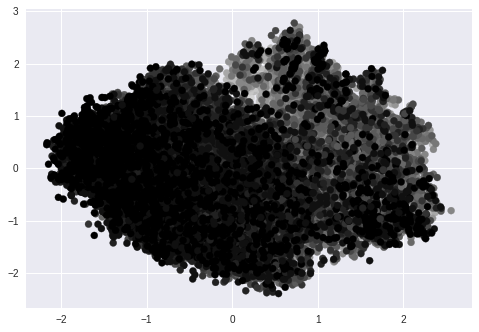

FCFP


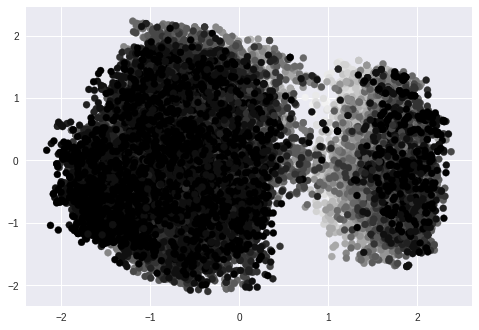

top


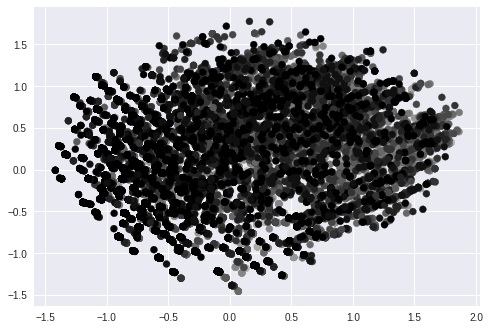

In [14]:
from sklearn.decomposition import PCA
def pca_lens(fp_arr, plot=True, c=desc_arr[:,0]):
    pca = PCA(n_components=2)
    lens = pca.fit_transform(fp_arr)
    if plot:
        plt.scatter(lens[:,0], lens[:,1], c=c)
        plt.show()
    return lens

for i, fp_arr in enumerate([ECFP_arr, FCFP_arr, top_arr]):
    print(fingerprint_names[i])
    pca_lens(fp_arr)

## Mapper hyperparameters

In [42]:
hyperparams = [{'Name': 'ECFP', 'fp_arr': ECFP_arr, 'lens': pca_lens(ECFP_arr, plot=False), 
                'cluster_params': {'eps': 0.65, 'min_samples': 4}, 'n_cubes': [30,30]},
               {'Name': 'FCFP', 'fp_arr': FCFP_arr, 'lens': pca_lens(FCFP_arr, plot=False), 
                'cluster_params': {'eps': 0.45, 'min_samples': 2}, 'n_cubes': [30,5]},
               {'Name': 'top', 'fp_arr': top_arr, 'lens': pca_lens(top_arr, plot=False),
                'cluster_params': {'eps': 0.25, 'min_samples': 2}, 'n_cubes': [10,10]}]

## Mapper Algorithm

> Check that the directory `networks/ZINC-FL_space/fingerprint_spaces` exists before running the following

In [44]:
import kmapper as km
from sklearn.cluster import DBSCAN

#### MAPPER HYPERPARAMETERS
perc_overlap = 0.4


for mapper_params in hyperparams:
    ### Extract mapper_params
    n_cubes = mapper_params['n_cubes']
    eps = mapper_params['cluster_params']['eps']
    min_samples = mapper_params['cluster_params']['min_samples']
    
    fp_arr = mapper_params['fp_arr']
    lens = mapper_params['lens']
    name = mapper_params['Name']
    cover = km.cover.Cover(n_cubes, perc_overlap)
    
    print(name, n_cubes, eps, min_samples)
    
    metric = 'jaccard'
    clusterer = DBSCAN(metric=metric, eps=eps, min_samples=min_samples, n_jobs=1)

    ### RANDOM SEED - useful for stochastic clustering method
    random_seed = 42
    np.random.seed(random_seed)

    ### MAPPER
    mapper = km.KeplerMapper(verbose=1)
    network = mapper.map(lens=lens,
                         X=fp_arr,
                         clusterer=clusterer,
                         cover=cover,
                         precomputed=False)
    ### VISUALISATION
    
    _ = mapper.visualize(network,
                     title='ZINC.FL: %s fingerprint' % name,
                     color_function=desc_arr[:,2]>0,
                     path_html='./networks/ZINC-FL_space/fingerprint_spaces/%s_network_nAro.html' % name,
                     custom_tooltips = tooltips,
                     custom_meta={'Color': 'Presence of Aromatic Rings'})
    
    _ = mapper.visualize(network,
                     title='ZINC.FL: %s fingerprint' % name,
                     color_function=desc_arr[:,1]>0,
                     path_html='./networks/ZINC-FL_space/fingerprint_spaces/%s_network_nRing.html' % name,
                     custom_tooltips = tooltips,
                     custom_meta={'Color': 'Presence of Rings'})


ECFP [30, 30] 0.65 4
KeplerMapper()
Mapping on data shaped (37660, 512) using lens shaped (37660, 2)

Creating 900 hypercubes.

Created 3561 edges and 1351 nodes in 0:00:23.209337.
Wrote visualization to: ./networks/ZINC-FL_space/fingerprint_spaces/ECFP_network_nRing.html
FCFP [30, 5] 0.45 2
KeplerMapper()
Mapping on data shaped (37660, 512) using lens shaped (37660, 2)

Creating 150 hypercubes.

Created 2459 edges and 1407 nodes in 0:01:39.656462.
Wrote visualization to: ./networks/ZINC-FL_space/fingerprint_spaces/FCFP_network_nRing.html
top [10, 10] 0.25 2
KeplerMapper()
Mapping on data shaped (37660, 512) using lens shaped (37660, 2)

Creating 100 hypercubes.

Created 687 edges and 329 nodes in 0:02:13.348307.
Wrote visualization to: ./networks/ZINC-FL_space/fingerprint_spaces/top_network_nRing.html
